In [2]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns

from steps.prepare_data import load_processed_data
from utils.model import predict, load_model

In [3]:
train_data, test_data = load_processed_data()

model_name = "XgboostV1_p072_r031_090auc.pickle"

train_data_x = train_data.drop(columns=["target"])
train_data_y = train_data["target"]

test_data_x = test_data.drop(columns=["target"])
test_data_y = test_data["target"]

print("-----------Train----------")
predict(model_name, train_data)

print("-----------Test----------")
predict(model_name, test_data)

model, features = load_model(model_name)

-----------Train----------

Metrics
AUC: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    140413
         1.0       0.83      0.40      0.54      9585

    accuracy                           0.96    149998
   macro avg       0.90      0.70      0.76    149998
weighted avg       0.95      0.96      0.95    149998

-----------Test----------

Metrics
AUC: 0.90
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    140597
         1.0       0.72      0.31      0.44      9403

    accuracy                           0.95    150000
   macro avg       0.84      0.65      0.70    150000
weighted avg       0.94      0.95      0.94    150000



In [11]:
# XGBoost
booster = model.get_booster()
importances = booster.get_score(importance_type="gain")
importance_df = pd.DataFrame(list(importances.items()), columns=["Feature", "Importance"])

# # LightGBM
# importances = model.booster_.feature_importance(importance_type="gain")
# importance_df = pd.DataFrame(list(zip(features, importances)), columns=["Feature", "Importance"])


# Report
feature_importances = importance_df.sort_values(by="Importance", ascending=False)
feature_importances = feature_importances[feature_importances.Importance > 15]

feature_importances

,Feature,Importance
420,num_act_days_min_mnt1,1044.641602
330,num_act_days_min_mnt3,602.182251
487,device_days_usage,327.491577
373,num_act_days_mea_mnt1,306.733246
495,device_brand_other,239.026230
...,...,...
115,non_accum_internet_vol_mea_wk1,15.184276
8,voice_out_tar_dur_std_mnt1,15.183282
534,bs_ovrl_OMO_CNT_M1,15.128779
322,gprs_tar_vol_mea_mnt1,15.067931


In [15]:
import plotly.express as px

fig = px.bar(feature_importances[:50], x="Importance", y="Feature", title="Feature Importances")
fig.update_layout(yaxis={"categoryorder": "total ascending"}, width=800, height=1200)
fig.show()

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(train_data_x)

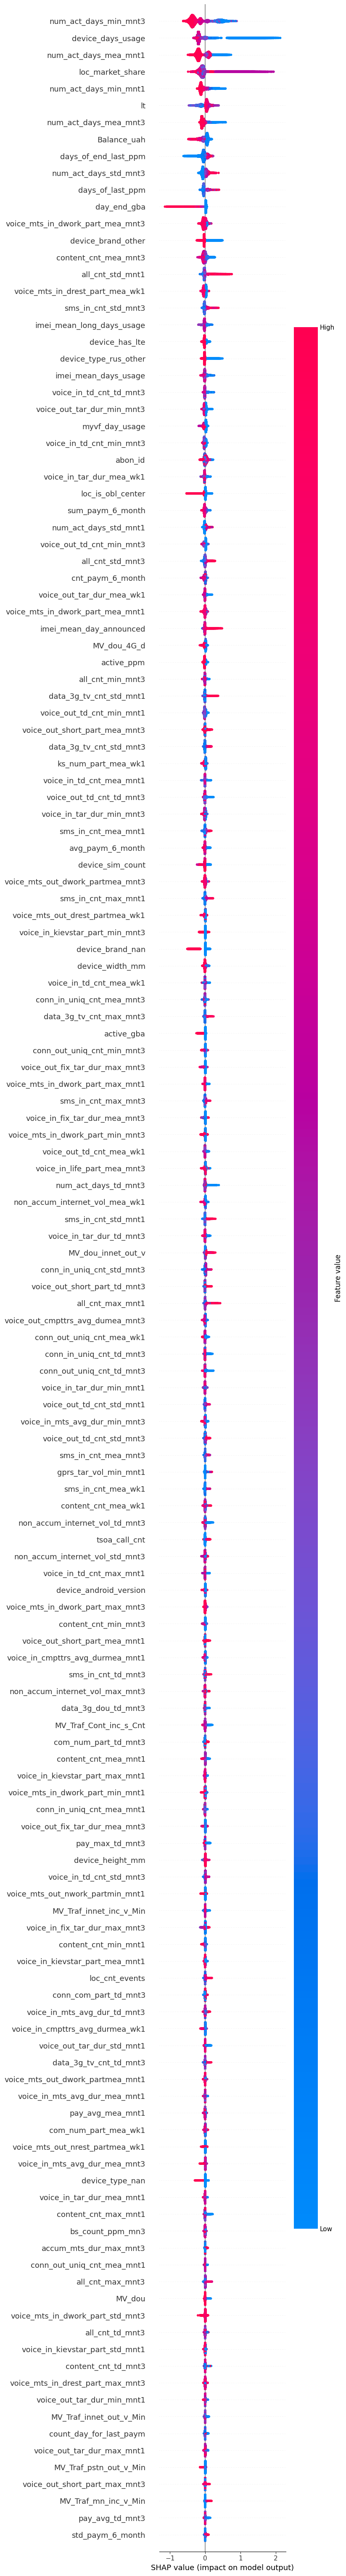

In [14]:
shap.summary_plot(shap_values, train_data_x, max_display=150, auto_size_plot=True)

In [7]:
# # Обчислення кореляційної матриці
# corr_matrix = train_data_x.corr()

In [8]:
# # Створення теплової карти за допомогою Plotly
# fig = px.imshow(
#     corr_matrix,
#     labels=dict(color="Correlation"),
#     x=train_data_x.columns,
#     y=train_data_x.columns,
#     title="Correlation Heatmap of 800 Features",
# )

# fig.update_layout(width=1000, height=1000)

# # Показати графік
# fig.show()

In [9]:
# # Clean highly correlated features

# threshold = 0.95
# top_importances = feature_importances[:50]

# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# to_drop = [
#     column
#     for column in upper.columns
#     if any(upper[column] > threshold) and not any(top_importances["Feature"].str.contains(column))
# ]

# print(top_importances[top_importances["Feature"].isin(to_drop)])

# df_reduced = train_data_x.drop(columns=to_drop)

In [10]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(model, threshold="mean")
selector.fit(train_data_x, train_data_y)

X_selected = selector.transform(train_data_x)

In [11]:
selected_features_mask = selector.get_support()

# Отримання списку вибраних ознак
selected_features = train_data_x.columns[selected_features_mask]

selected_features.to_numpy()

array(['all_cnt_min_mnt3', 'days_of_end_last_ppm', 'device_days_usage',
       'loc_is_obl_center', 'loc_market_share', 'num_act_days_mea_mnt3',
       'num_act_days_min_mnt1', 'num_act_days_min_mnt3',
       'num_act_days_std_mnt3', 'voice_in_mts_avg_dur_min_mnt3',
       'voice_in_tar_dur_max_mnt1', 'voice_in_tar_dur_mea_wk1',
       'voice_in_tar_dur_min_mnt1', 'voice_in_td_cnt_mea_mnt3',
       'voice_in_td_cnt_mea_wk1', 'voice_mts_in_dwork_part_max_mnt1'],
      dtype=object)

In [12]:
# fetch array from json file
import json

with open("LightGbmV1_p041_r064_089auc.json", "r") as f:
    LightGbmV1_p041_r064_089auc = json.load(f)

with open("LightGbmV2_p069_r033_090auc_features.json", "r") as f:
    LightGbmV2_p069_r033_090auc_features = json.load(f)

with open("XgboostV1_p070_r032_090auc.json", "r") as f:
    XgboostV1_p070_r032_090auc = json.load(f)


new_features = set(LightGbmV1_p041_r064_089auc + LightGbmV2_p069_r033_090auc_features + XgboostV1_p070_r032_090auc)

new_features

{'Balance_uah',
 'MV_ARPU',
 'MV_Traf_2G_d_Mb',
 'MV_Traf_3G_d_Mb',
 'MV_Traf_4G_d_Mb',
 'MV_Traf_ACCA_out_v_Min',
 'MV_Traf_Cont_inc_s_Cnt',
 'MV_Traf_Cont_out_v_Min',
 'MV_Traf_inc_s_Cnt',
 'MV_Traf_innet_inc_v_Min',
 'MV_Traf_innet_out_v_Min',
 'MV_Traf_omo_inc_v_Min',
 'MV_dou',
 'MV_dou_2G_d',
 'MV_dou_4G_d',
 'MV_dou_data',
 'MV_dou_innet_out_v',
 'MV_dou_net',
 'MV_net_total',
 'TM_ID',
 'abon_id',
 'accum_mts_dur_max_mnt3',
 'accum_mts_dur_mea_mnt3',
 'accum_mts_dur_std_mnt3',
 'accum_mts_dur_td_mnt3',
 'accum_oth_dur_td_mnt3',
 'all_clc_max_mnt3',
 'all_clc_mea_mnt1',
 'all_clc_mea_mnt3',
 'all_clc_std_mnt3',
 'all_clc_td_mnt3',
 'all_cnt_max_mnt1',
 'all_cnt_max_mnt3',
 'all_cnt_mea_mnt1',
 'all_cnt_mea_mnt3',
 'all_cnt_mea_wk1',
 'all_cnt_min_mnt1',
 'all_cnt_min_mnt3',
 'all_cnt_std_mnt1',
 'all_cnt_std_mnt3',
 'all_cnt_td_mnt3',
 'all_home_clc_max_mnt3',
 'all_home_clc_mea_mnt3',
 'all_home_clc_std_mnt3',
 'all_home_clc_td_mnt3',
 'avg_paym_6_month',
 'bs_ovrl_OMO_CNT_M3',

: 

In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df["set"] = "train"
    data_df = pd.concat([data_df, test.copy()]).fillna("test")
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue] == s, feature]
        # Filter 'selection' to include only the central 95% of the data
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()


for feature in train.columns:
    plot_distribution_pairs(train, test, feature, palette=color_list)